In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_datasets import download
# from tensorflow_datasets.core.download import download_manager as dm
# import tensorflowdownload.DownloadManager as dm

# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout,BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.python.keras.optimizer_v2.gradient_descent import SGD

In [ ]:
import tensorflow_datasets as tfds

pcam, pcam_info = tfds.load("patch_camelyon", with_info=True)
print(pcam_info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteKJFFG9/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteKJFFG9/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteKJFFG9/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
      

In [ ]:
# To keep the dataset size small PatchCAMELYON is stored as int8 patches. 
#For network training we need float32 and we want to normalize between 0 and 1. The function below performs this task.


def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [ ]:
print(pcam['train'].__len__())
print(pcam['validation'].__len__())
print(pcam['test'].__len__())

tf.Tensor(262144, shape=(), dtype=int64)
tf.Tensor(32768, shape=(), dtype=int64)
tf.Tensor(32768, shape=(), dtype=int64)


In [ ]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

In [ ]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)

In [ ]:
model = Sequential()

base_model=ResNet50(include_top=False, pooling='avg')

In [ ]:
for layer in base_model.layers[:]:
   layer.trainable = False

In [ ]:
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.build((None, 96, 96, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_6 (ModuleWrap (None, 2048)              23587712  
_________________________________________________________________
module_wrapper_7 (ModuleWrap (None, 2048)              0         
_________________________________________________________________
module_wrapper_8 (ModuleWrap (None, 2048)              0         
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 64)                131136    
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 64)                0         
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 2)                 130       
Total params: 23,718,978
Trainable params: 131,266
Non-trainable params: 23,587,712
____________________________________

In [ ]:
# Short training ONLY my top layers 
model.compile(optimizer=SGD(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_pipeline,
                 validation_data=valid_pipeline, batch_size=64,
                 verbose=1, epochs=3, steps_per_epoch=4096, validation_steps=512)

Epoch 1/3
4096/4096 [==============================] - 152s 36ms/step - loss: 0.6937 - accuracy: 0.5091 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 2/3
4096/4096 [==============================] - 153s 37ms/step - loss: 0.6927 - accuracy: 0.5114 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 3/3
4096/4096 [==============================] - 150s 37ms/step - loss: 0.6921 - accuracy: 0.5162 - val_loss: 0.6932 - val_accuracy: 0.5026


In [ ]:
# Make last block of the base model trainable:

for layer in base_model.layers[:81]:
   layer.trainable = False
for layer in base_model.layers[81:]:
   layer.trainable = True

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_6 (ModuleWrap (None, 2048)              23587712  
_________________________________________________________________
module_wrapper_7 (ModuleWrap (None, 2048)              0         
_________________________________________________________________
module_wrapper_8 (ModuleWrap (None, 2048)              0         
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 64)                131136    
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 64)                0         
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 2)                 130       
Total params: 23,718,978
Trainable params: 22,215,874
Non-trainable params: 1,503,104
__________________________________

In [ ]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
# Compile frozen base model + unfrozen top block + my top layer with small lr

opt = SGD(learning_rate=1e-5, momentum=0.9, decay=0.0, nesterov=True)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

m = model.fit(train_pipeline,
                 validation_data=valid_pipeline, batch_size=64,
                 verbose=1, epochs=30, steps_per_epoch=4096, validation_steps=512)

Epoch 1/30
4096/4096 [==============================] - 274s 66ms/step - loss: 0.6626 - accuracy: 0.6679 - val_loss: 0.5215 - val_accuracy: 0.7351
Epoch 2/30
4096/4096 [==============================] - 268s 65ms/step - loss: 0.5330 - accuracy: 0.7479 - val_loss: 0.4909 - val_accuracy: 0.7551
Epoch 3/30
4096/4096 [==============================] - 268s 65ms/step - loss: 0.4966 - accuracy: 0.7702 - val_loss: 0.4728 - val_accuracy: 0.7635
Epoch 4/30
4096/4096 [==============================] - 268s 65ms/step - loss: 0.4744 - accuracy: 0.7829 - val_loss: 0.4693 - val_accuracy: 0.7731
Epoch 5/30
4096/4096 [==============================] - 269s 66ms/step - loss: 0.4587 - accuracy: 0.7920 - val_loss: 0.4706 - val_accuracy: 0.7719
Epoch 6/30
4096/4096 [==============================] - 268s 65ms/step - loss: 0.4460 - accuracy: 0.8002 - val_loss: 0.4585 - val_accuracy: 0.7808
Epoch 7/30
4096/4096 [==============================] - 270s 66ms/step - loss: 0.4339 - accuracy: 0.8050 - val_loss: 0

In [28]:
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.7670


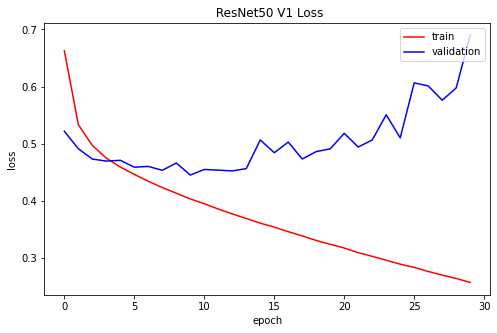

In [ ]:
# summarize history for loss
plt.figure(figsize=(8,5))
plt.plot(m.history['loss'],color='r')
plt.plot(m.history['val_loss'],color="blue")
plt.title(' ResNet50 V1 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

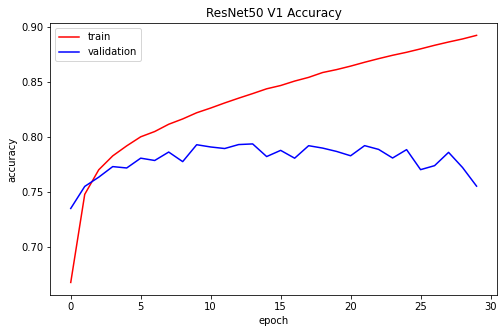

In [27]:
# summarize history for accuracy
plt.figure(figsize=(8,5))
plt.plot(m.history['accuracy'],color='r')
plt.plot(m.history['val_accuracy'],color="blue")
plt.title('ResNet50 V1 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()